In [19]:
ALPHA = 1

# Ridge Regression - some Theory

* Todo

# Get the data

In [28]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from collections import namedtuple
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
Supervised = namedtuple("supervised", ["features", "target", "feature_names"])

def split_test_train(data):
    X_train, X_test, Y_train, Y_test = train_test_split(data.features, data.target, test_size = 0.2, random_state=5)
    train = Supervised(X_train, Y_train.reshape(-1, 1), feature_names=data.feature_names)
    test = Supervised(X_test, Y_test.reshape(-1, 1), feature_names=data.feature_names)
    return train, test 


def normalize(train: Supervised, test: Supervised):
    mu = train.features.mean(axis=0)
    std = train.features.std(axis=0)
    train_scaled = Supervised(features=(train.features - mu) / std, 
                              target=train.target, 
                              feature_names=train.feature_names) 
    test_scaled = Supervised(features=(test.features - mu) / std, 
                             target=test.target, 
                             feature_names=test.feature_names)
    return train_scaled, test_scaled


housing = fetch_california_housing()
train_data, test_data = normalize(*split_test_train(Supervised(housing.data, housing.target, housing.feature_names)))

# Ridge Regression via the Normal equation - with Tensorflow

In [29]:
def add_intercept(features):
    """Add intercept to features
    Todo: as an exercise use tensorflow"""
    m, n = features.shape
    return np.c_[np.ones((m, 1)), features]

    
def train(data, alpha):
    X = add_intercept(data.features)
    Y = data.target
    XT = tf.transpose(X)
    cov = tf.matmul(XT, X)
    one = tf.eye(cov.shape[0], dtype=tf.dtypes.float64)
    inv = tf.linalg.inv(cov + alpha * one)
    return tf.matmul(tf.matmul(inv, XT), Y)


def predict(data, theta):
    return tf.matmul( add_intercept(data.features),  theta)

theta_analytic = train(train_data, ALPHA)
y_pred_analytic  = predict(test_data, theta_analytic)

# Sklearn

In [119]:
# For comparison perform linear regression with scikit learn
from sklearn.linear_model import Ridge
#from sklearn.linear_model import LinearRegression

lin_model = Ridge(alpha=ALPHA, fit_intercept=True, normalize=False)
lin_model.fit(train_data.features, train_data.target)
theta_sklearn = tf.concat((lin_model.intercept_, lin_model.coef_.flatten()), axis=0)
y_pred_sklearn = lin_model.predict(test_data.features)

# Ridge Regression as a Neural Network with Tensorflow / Keras 
* Idea: use keras wit 1 layer, identitiy as activation function
* Assume that we could not find the minimizer analytically. 
* Thus we wish to find the minimzer computationally.

> **Note** the accuracy with an explicit optimizier critically hinges on the convergence behaviour of the optimizer.  In this case wie use the Adam optimizer with learning rate = 0.01. It's instructive to break the model by employing a non-convergent optimizer (e.g. RSMprops with learnin rate 0.01 for this particular case).

In [207]:
from tensorflow.keras import regularizers
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd



def plot_keras_training(history):
    plt.figure(figsize=(15,4))
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
    plotter.plot({'Basic': history}, metric = "mse")
    #plt.ylim([0, 3])
    #plt.xlim([0,30])
    plt.ylabel('MSE')
    plt.show()

init_kernel = lambda shape, dtype: tf.constant(lin_model.coef_.reshape(shape), dtype=dtype)
init_bias = lambda shape, dtype: tf.constant(lin_model.intercept_.reshape(shape), dtype=dtype)

    
def build_model():
    """Regularization via kernel and bias regularizer
    Todo: via loss 
    """
    model = keras.Sequential([layers.Dense(1, 
                                           activation='linear', 
                                           input_shape=[8]
                                           ,kernel_regularizer=regularizers.l2(ALPHA) 
                                           ,bias_regularizer=regularizers.l2(ALPHA)
                                           ,kernel_initializer=init_kernel
                                           ,bias_initializer=init_bias
                                           
                                          )])
    optimizer = tf.keras.optimizers.Adam(0.001)
    #optimizer = tf.keras.optimizers.SGD(0.001)
    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mse'])
    return model

model = build_model()
model.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 1)                 9         
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________


In [208]:
EPOCHS = 5000

history = model.fit(
  train_data.features, train_data.target,
  epochs=EPOCHS, 
  batch_size = train_data.features.shape[0], validation_split = 0., verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:7.2198,  mse:0.5214,  
....................................................................................................
Epoch: 100, loss:6.2624,  mse:0.5433,  
....................................................................................................
Epoch: 200, loss:5.5137,  mse:0.5923,  
....................................................................................................
Epoch: 300, loss:4.9305,  mse:0.6645,  
....................................................................................................
Epoch: 400, loss:4.4787,  mse:0.7528,  
....................................................................................................
Epoch: 500, loss:4.1301,  mse:0.8506,  
....................................................................................................
Epoch: 600, loss:3.8622,  mse:0.9521,  
....................................................................................................
Epoch: 700, lo

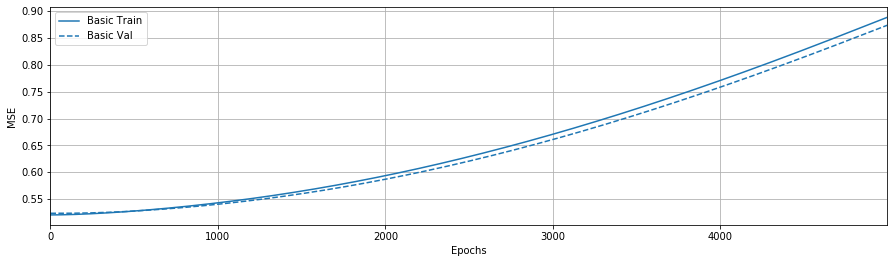

In [204]:
plot_keras_training(history)

In [206]:
theta_keras = tf.concat((model.weights[1], tf.reshape(model.weights[0], [8])), axis=0)
y_pred_keras = model.predict(test_data.features)

In [167]:
l = model.get_layer(index=0)

In [168]:
l.get_weights()[0].shape

(8, 1)

# Ridge Regression using the estimator API
* within the estimator API the number of training steps is controlled via the the `dataset`
* more precisely via the `repeat` keyword

In [33]:
"""
from tensorflow.estimator import LinearRegressor
from tensorflow import feature_column

def input_fn(data: Supervised, train=False):
    #Todo: make callable class for more intuitive usage lateron
    raw_xs = pd.DataFrame(data.features, columns = data.feature_names)
    xs = {key:np.array(value) for key,value in dict(raw_xs).items()} 
    ys = data.target
    ds = tf.data.Dataset.from_tensor_slices((xs, ys)).batch(raw_xs.shape[0])
    if train:
        return ds.repeat(200)
    return ds

feature_columns = [feature_column.numeric_column(f) for f in housing.feature_names]
linear_regressor = LinearRegressor(feature_columns=feature_columns)
linear_regressor.train(lambda: input_fn(train_data, train=True))
y_pred_estimator = np.array([r["predictions"] for r in linear_regressor.predict(lambda: input_fn(test_data, train=False))])
"""

'\nfrom tensorflow.estimator import LinearRegressor\nfrom tensorflow import feature_column\n\ndef input_fn(data: Supervised, train=False):\n    #Todo: make callable class for more intuitive usage lateron\n    raw_xs = pd.DataFrame(data.features, columns = data.feature_names)\n    xs = {key:np.array(value) for key,value in dict(raw_xs).items()} \n    ys = data.target\n    ds = tf.data.Dataset.from_tensor_slices((xs, ys)).batch(raw_xs.shape[0])\n    if train:\n        return ds.repeat(200)\n    return ds\n\nfeature_columns = [feature_column.numeric_column(f) for f in housing.feature_names]\nlinear_regressor = LinearRegressor(feature_columns=feature_columns)\nlinear_regressor.train(lambda: input_fn(train_data, train=True))\ny_pred_estimator = np.array([r["predictions"] for r in linear_regressor.predict(lambda: input_fn(test_data, train=False))])\n'

# Comparision of results

In [209]:
def mse(y_true, y_pred):
    return tf.reduce_sum((y_true - y_pred)**2) / y_true.shape[0]

In [210]:
mse(test_data.target,  y_pred_sklearn) 

<tf.Tensor: shape=(), dtype=float64, numpy=0.5363392915031693>

In [211]:
mse(test_data.target,  y_pred_analytic) 

<tf.Tensor: shape=(), dtype=float64, numpy=0.5363429005540788>

In [212]:
mse(test_data.target,  y_pred_keras)

<tf.Tensor: shape=(), dtype=float64, numpy=1.579014018327798>

In [16]:
mse(test_data.target,  y_pred_estimator) 

NameError: name 'y_pred_estimator' is not defined

In [110]:
theta_sklearn

<tf.Tensor: shape=(9,), dtype=float64, numpy=
array([ 2.06389635,  0.82785305,  0.11548134, -0.28098196,  0.32407719,
       -0.00341544, -0.04502633, -0.89539994, -0.86731315])>

In [ ]:
theta_sklearn

In [111]:
theta_keras

<tf.Tensor: shape=(9,), dtype=float32, numpy=
array([ 1.0333623 ,  0.38085666,  0.07087589,  0.04344954, -0.02072311,
        0.00208555, -0.02143203, -0.10608892, -0.05716152], dtype=float32)>

In [ ]:
theta_analytic